In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 100行"深度学习"框架

Credit：[karpathy/micrograd](https://github.com/karpathy/micrograd)

In [2]:
def unbroadcast(out, shape):
    sum_axis = [i for i in range(len(shape)) if shape[i]==1 and out.shape[i] > 1]
    return out.sum(axis=tuple(sum_axis)).reshape(shape)

class Tensor(object):
    def __init__(self, data, children=(), op="", grad_required=True, name=""):
        self.data = data
        self.grad_required = grad_required
        self.grad = np.zeros_like(data) if grad_required else None
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(children)
        self._op = op
        self._name = name
        
    def zero_grad(self):
        if self.grad_required:
            self.grad = np.zeros_like(self.data)
            
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = np.ones_like(self.data)
        for v in reversed(topo):
            v._backward()

    # operators
    def mean(self):
        out = Tensor(self.data.mean(), (self, ), 'mean')
        
        def _backward():
            if self.grad_required:
                self.grad += out.grad * np.ones_like(self.grad) / self.grad.data.shape[0]
        out._backward = _backward
        
        return out
    
    def matmul(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other, grad_required=False)
        out = Tensor(self.data @ other.data, (self, other), 'matmul')
        
        def _backward():
            if self.grad_required:
                self.grad += out.grad @ other.data.T
            if other.grad_required:
                other.grad += self.data.T @ out.grad
        out._backward = _backward

        return out

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other, grad_required=False)
        out = Tensor(self.data + other.data, (self, other), '+')

        def _backward():
            if self.grad_required:
                self.grad += unbroadcast(out.grad, self.grad.shape)
            if other.grad_required:
                other.grad += unbroadcast(out.grad, other.grad.shape)
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other, grad_required=False)
        out = Tensor(self.data * other.data, (self, other), '*')

        def _backward():
            if self.grad_required:
                self.grad += unbroadcast(other.data * out.grad, self.grad.shape)
            if other.grad_required:
                other.grad += unbroadcast(self.data * out.grad, other.grad.shape)
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Tensor(self.data**other, (self,), f'**{other}')

        def _backward():
            if self.grad_required:
                self.grad += unbroadcast((other * self.data**(other-1)) * out.grad, self.grad.shape)
        out._backward = _backward

        return out

    def relu(self):
        out = Tensor(np.maximum(self.data, 0), (self,), 'relu')

        def _backward():
            if self.grad_required:
                self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Tensor(data={self.data}, grad={self.grad}, shape={self.data.shape})"

# 框架应用

/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


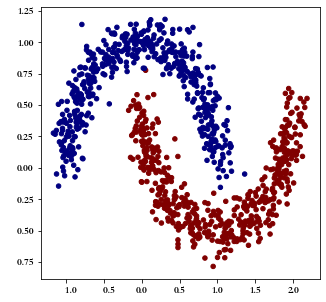

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [4]:
class Model(object):
    def __init__(self):
        self.w1 = Tensor(np.random.uniform(-1,1,(2,16)), name="w1")
        self.b1 = Tensor(np.random.uniform(-1,1,(1,16)), name="b1")
        self.w2 = Tensor(np.random.uniform(-1,1,(16,16)), name="w2")
        self.b2 = Tensor(np.random.uniform(-1,1,(1,16)), name="b2")
        self.w3 = Tensor(np.random.uniform(-1,1,(16,1)), name="w3")
        self.b3 = Tensor(np.random.uniform(-1,1,(1,1)), name="b3")
        self.params = [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3]
    def forward(self, x):
        t = Tensor(x.reshape(-1,2), grad_required=False)
        h1 = t.matmul(self.w1) + self.b1
        h1 = h1.relu()
        h2 = h1.matmul(self.w2) + self.b2
        h2 = h2.relu()
        out = h2.matmul(self.w3) + self.b3
        return out
    def zero_grad(self):
        for param in self.params:
            param.zero_grad()

In [5]:
m = Model()

In [6]:
def train(epochs, learning_rate):
    for i in range(epochs):
        p = m.forward(X)
        loss = (1-p*y.reshape(-1,1)).relu()
        loss = loss.mean()
        m.zero_grad()
        loss.backward()
        for param in m.params:
            param.data -= param.grad*learning_rate
        print(f"epoch = {i}, loss = {loss.data}")

In [7]:
train(epochs=1000, learning_rate=0.1)

epoch = 0, loss = 0.9402381807897122
epoch = 1, loss = 0.49475430385979846
epoch = 2, loss = 0.4172692037011329
epoch = 3, loss = 0.3652292650196348
epoch = 4, loss = 0.33442578912216037
epoch = 5, loss = 0.3093425043666872
epoch = 6, loss = 0.28889777223228774
epoch = 7, loss = 0.279948641101774
epoch = 8, loss = 0.2724523105439782
epoch = 9, loss = 0.2674086569273571
epoch = 10, loss = 0.26715891535606945
epoch = 11, loss = 0.24757668191096693
epoch = 12, loss = 0.24081093602116202
epoch = 13, loss = 0.2387525091906173
epoch = 14, loss = 0.24239243246432712
epoch = 15, loss = 0.2242348929355168
epoch = 16, loss = 0.2149753527447917
epoch = 17, loss = 0.2097177180341825
epoch = 18, loss = 0.20496275633992617
epoch = 19, loss = 0.20075050370146272
epoch = 20, loss = 0.19699211106896458
epoch = 21, loss = 0.19400475022682767
epoch = 22, loss = 0.1929490623264611
epoch = 23, loss = 0.19117623725929964
epoch = 24, loss = 0.1942938280862133
epoch = 25, loss = 0.18919368644663248
epoch = 26

epoch = 314, loss = 0.018900195580299376
epoch = 315, loss = 0.01857822079518602
epoch = 316, loss = 0.018783765793926065
epoch = 317, loss = 0.018489519390881955
epoch = 318, loss = 0.01864549134439767
epoch = 319, loss = 0.01842255417258345
epoch = 320, loss = 0.018605991418706273
epoch = 321, loss = 0.01843684649144778
epoch = 322, loss = 0.018514636522438625
epoch = 323, loss = 0.01848246704531834
epoch = 324, loss = 0.01854405707375474
epoch = 325, loss = 0.018426916629915142
epoch = 326, loss = 0.01856837719199569
epoch = 327, loss = 0.01835615247400798
epoch = 328, loss = 0.018282627884835378
epoch = 329, loss = 0.018313529476514937
epoch = 330, loss = 0.01830491635990172
epoch = 331, loss = 0.01822898428472983
epoch = 332, loss = 0.018079867894401656
epoch = 333, loss = 0.01812606380119003
epoch = 334, loss = 0.017828367838373802
epoch = 335, loss = 0.017714336030655763
epoch = 336, loss = 0.017633442809196622
epoch = 337, loss = 0.017609587158379576
epoch = 338, loss = 0.01744

epoch = 533, loss = 0.012410805470455746
epoch = 534, loss = 0.012372961523229734
epoch = 535, loss = 0.012432868671791537
epoch = 536, loss = 0.012568602465409707
epoch = 537, loss = 0.012499485364953265
epoch = 538, loss = 0.012458794157900134
epoch = 539, loss = 0.012325757753199273
epoch = 540, loss = 0.012300348880111283
epoch = 541, loss = 0.012273028263774044
epoch = 542, loss = 0.012257503721070056
epoch = 543, loss = 0.012289496219849557
epoch = 544, loss = 0.012344208546058154
epoch = 545, loss = 0.012401429909702935
epoch = 546, loss = 0.01232661284765739
epoch = 547, loss = 0.012359303980755637
epoch = 548, loss = 0.012279195540857895
epoch = 549, loss = 0.012346993709539
epoch = 550, loss = 0.012246707922973513
epoch = 551, loss = 0.01225054095790929
epoch = 552, loss = 0.012164516869139106
epoch = 553, loss = 0.012279573474465587
epoch = 554, loss = 0.012245366914749587
epoch = 555, loss = 0.012226424162114214
epoch = 556, loss = 0.012125450136880671
epoch = 557, loss = 0

epoch = 740, loss = 0.010280891173019512
epoch = 741, loss = 0.010273990167193119
epoch = 742, loss = 0.010267392488624533
epoch = 743, loss = 0.010263169346188296
epoch = 744, loss = 0.010261241364417764
epoch = 745, loss = 0.010271270862358057
epoch = 746, loss = 0.010267670393930011
epoch = 747, loss = 0.010241771904232238
epoch = 748, loss = 0.010232815075650119
epoch = 749, loss = 0.010226368292156621
epoch = 750, loss = 0.010220441391939637
epoch = 751, loss = 0.010215480604166105
epoch = 752, loss = 0.010209219011277727
epoch = 753, loss = 0.010201391064169249
epoch = 754, loss = 0.010195214819218954
epoch = 755, loss = 0.010204888818612616
epoch = 756, loss = 0.010232971985649559
epoch = 757, loss = 0.010204329304590967
epoch = 758, loss = 0.010176145214882634
epoch = 759, loss = 0.01017133090876742
epoch = 760, loss = 0.010216411692359624
epoch = 761, loss = 0.010238555890649596
epoch = 762, loss = 0.010258026491873032
epoch = 763, loss = 0.010250089084673238
epoch = 764, loss

epoch = 967, loss = 0.008813997927514174
epoch = 968, loss = 0.0087774636661487
epoch = 969, loss = 0.008771548889969559
epoch = 970, loss = 0.008758412947962925
epoch = 971, loss = 0.008745184941116797
epoch = 972, loss = 0.008738803927000332
epoch = 973, loss = 0.00873951094143163
epoch = 974, loss = 0.008737938760870242
epoch = 975, loss = 0.008757344594466731
epoch = 976, loss = 0.008840738316076794
epoch = 977, loss = 0.008909278574136856
epoch = 978, loss = 0.008871294708838963
epoch = 979, loss = 0.009015427195343378
epoch = 980, loss = 0.008790114035302098
epoch = 981, loss = 0.008819243349151143
epoch = 982, loss = 0.008781754876541047
epoch = 983, loss = 0.008812782790142967
epoch = 984, loss = 0.008767596645221126
epoch = 985, loss = 0.008806321653873907
epoch = 986, loss = 0.008753421052205227
epoch = 987, loss = 0.008801365878617361
epoch = 988, loss = 0.008783907673629006
epoch = 989, loss = 0.008904976916698419
epoch = 990, loss = 0.008753458964689558
epoch = 991, loss =

(-1.785699887074708, 1.964300112925292)

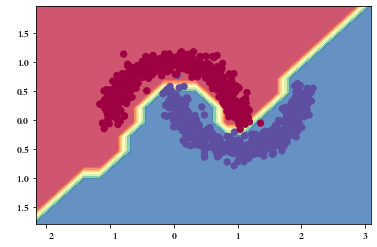

In [8]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
scores = [m.forward(i) for i in Xmesh]
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# 神经网路图分析

In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        label = f"Tensor({n._name},shape={n.data.shape})" if n._name else f"Tensor(shape={n.data.shape})"
        dot.node(name=str(id(n)), label=label, shape="record")
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [10]:
z = m.forward(X[0])

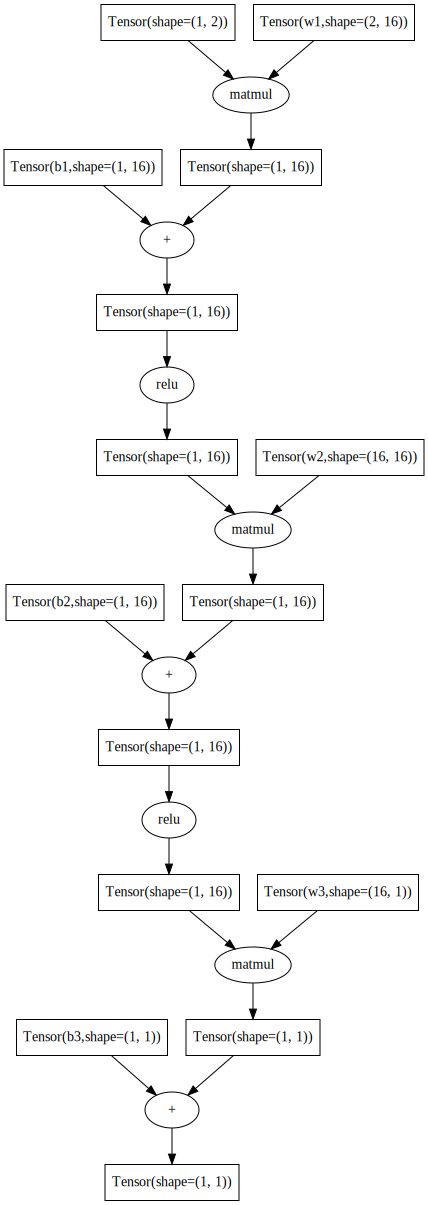

In [11]:
draw_dot(z, rankdir="TB")

In [13]:
z

Tensor(data=[[2.97820756]], grad=[[0.]], shape=(1, 1))

In [14]:
z.backward()

In [15]:
z

Tensor(data=[[2.97820756]], grad=[[1.]], shape=(1, 1))